In [35]:
#参考: https://qiita.com/To_Murakami/items/35d1b3144a0d017ad0ee

########パッケージのインポート#########
from __future__ import absolute_import, unicode_literals
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import tfgraphviz as tfg

In [36]:
########種々のメソッドの定義#########

#畳み込み層の定義
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#プーリング層の定義
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# アフィン層の重みを決めるメソッド
def weight(shape = []):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)

#アフィン層のバイアスを決めるメソッド
def bias(dtype = tf.float32, shape = []):
    initial = tf.zeros(shape, dtype = dtype)
    return tf.Variable(initial) 

#損失関数のメソッド
def loss(t, f):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(f)))
    return cross_entropy

#精度を算出するメソッド
def accuracy(t, f):
    correct_prediction = tf.equal(tf.argmax(t, 1), tf.argmax(f, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [37]:
##############ニューラルネットワークの構造を定義する#################

#次元数を定義する
Q = 784
P = 784
R = 10

#セッション生成
sess = tf.InteractiveSession()

#アフィン層を作る(f = Wx + b)
##Q次元のベクトルをいくつか並べた行列Xを定義（"いくつか"という部分はプレースホルダとしてあとで設定する）
X = tf.placeholder(dtype = tf.float32, shape = [None, Q])
t = tf.placeholder(dtype = tf.float32, shape = [None, R])

#第一の畳込みとプーリングの計算
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(X, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#第二の畳込みとプーリングの計算
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#全結合層の計算
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#DropOutの計算
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#読み出し層
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
#ソフトマックス関数を返す
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#損失関数
loss = loss(t, y_conv)
acc = accuracy(t, y_conv)

#最適化アルゴリズムを設定(最急降下法)
#opitimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
#最適化アルゴリズムを設定(Adam)
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)


#グラフ描画
#tfg.board(tf.get_default_graph())

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.0521, loss 309.426
step 20, training accuracy 0.7973, loss 35.4658
step 40, training accuracy 0.8962, loss 21.7116
step 60, training accuracy 0.9209, loss 13.9561
step 80, training accuracy 0.9272, loss 9.41842
step 100, training accuracy 0.9439, loss 6.86218
step 120, training accuracy 0.9513, loss 9.33895
step 140, training accuracy 0.9558, loss 8.39538
step 160, training accuracy 0.9561, loss 3.98327
step 180, training accuracy 0.9532, loss 9.36521


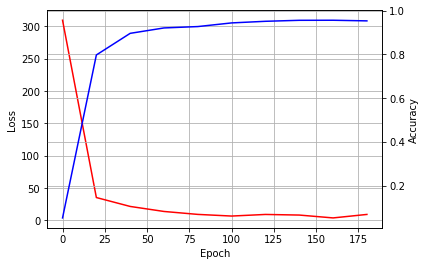

In [40]:
##############学習とテストを行う#################


#初期化
init_op = tf.global_variables_initializer()

#初期化の実行
sess.run(init_op)

#TensorFlowのAPIを使用してMNISTのデータを取得する
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#プロットに使用するリストを定義する
epoch_list=[]
acc_list=[]
loss_list=[]

#学習の実行
#50個のサンプルによるミニバッチ学習
##200回のエポック数で学習させる
for epoch in range(200):
    #バッチ数を50とし，データセットからランダムで取得する
    batch = mnist.train.next_batch(50)
    #20エポック毎にテストデータでテストさせる
    if epoch % 20 == 0:
        #精度を算出
        test_accuracy = acc.eval(feed_dict={
            X: mnist.test.images, t: mnist.test.labels, keep_prob: 1.0})
        #損失を算出
        test_loss = loss.eval(feed_dict={
            X: batch[0], t: batch[1], keep_prob: 1.0})
        print 'step %d, training accuracy %g, loss %g' % (epoch, test_accuracy, test_loss)
        #後ほどグラフで使用するのでエポック数，精度，損失をリストに格納しておく
        epoch_list.append(epoch)
        acc_list.append(test_accuracy)
        loss_list.append(test_loss)
    train_step.run(feed_dict={X: batch[0], t: batch[1], keep_prob: 0.5})


# 損失率と精度のプロット
fig , ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid()
p1 = ax.plot(epoch_list, loss_list, color='red')
p2 = ax2.plot(epoch_list, acc_list,color='blue')
ax.legend()
ax2.legend()
plt.show()

sess.close()